<a href="https://colab.research.google.com/github/Calista-F/ECG-signal-denoising/blob/main/20220225_Wavelet_runthrough_ECG_pywt_signal_0_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pywt
from skimage.restoration import denoise_wavelet
import matplotlib.pyplot as plt
import pandas as pd
from math import log10, sqrt
import cv2
import numpy as np

In [2]:
from sklearn.metrics import  mean_squared_error, mean_absolute_error, max_error
import math

def get_rmse(y_target, y_computed):
  RMSE = mean_squared_error(y_target, y_computed, squared=False)
  return RMSE

In [3]:
def get_min_rmse(df):
  return df[df['RMSE'] == df['RMSE'].min()]

In [4]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [5]:
from scipy.misc import electrocardiogram

##Sigma =0.05

In [6]:
x = pywt.data.ecg().astype(float)/256

sigma = 0.5
x_noisy = x + sigma * np.random.randn(x.size)


#DENOISING
##########
#x_denoised = denoise_wavelet(x_noisy, method = 'BayesShrink', mode ='soft', wavelet_levels = 3, wavelet = 'sym8', rescale_sigma = 'True')

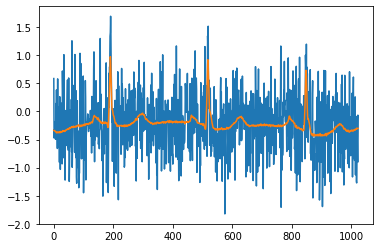

In [7]:
noisy_norm_df = pd.DataFrame(x_noisy)
signal_norm_df = pd.DataFrame(x)
plt.plot(noisy_norm_df)
plt.plot(signal_norm_df)

In [8]:
metrics = ['RMSE','MAE','MAX']
wavelets = ['sym5','db13','coif1']
sym_wavelets = ['sym'+str(i) for i in range(2,21)]
db_wavelets = ['db'+str(i) for i in range(1,39)]
coif_wavelets = ['coif'+str(i) for i in range(1,18)]
levels = np.arange(1,5,1)
methods = ['BayesShrink','VisuShrink']
indexcol = ['RMSE','MAE','MAX']

signalno = 'signal 60'
signaldistance = '5 kpc'

Create a main list that appends each line and each metric result

In [9]:
main_list = []

for m in methods:
  cols = []
  for i in range(len(sym_wavelets)):
    for l in range(len(levels)):
      #Make a dataframe for the denoised signal of the noisy normalized signal
      denoised_df = pd.DataFrame(denoise_wavelet(x_noisy, method = m, mode ='hard', wavelet = sym_wavelets[i], wavelet_levels = levels[l], rescale_sigma = 'True'))
      
      #Create col1- a list that contains the signal properties (which signal template was used), denoising properties, and denoising performance metrics
      col1 = [str(m).upper() +', '+ sym_wavelets[i] + ' level ' + str(levels[l])] 
      col1.append(get_rmse(signal_norm_df, denoised_df))
      col1.append(mean_absolute_error(signal_norm_df, denoised_df))
      col1.append(max_error(signal_norm_df, denoised_df))

      #append this column to cols- a list of columns for the table 
      cols.append(col1)
  main_list.append(cols)

  main_array = np.array(main_list)

In [10]:
def denoising_metrics(wavelet_family, max_level):

  main_list = []
  for m in methods:
    cols = []
    for i in range(len(wavelet_family)):
      for l in range(len(np.arange(1,max_level,1))):
        #Make a dataframe for the denoised signal of the noisy normalized signal
        denoised_df = pd.DataFrame(denoise_wavelet(x_noisy, method = m, mode ='hard', wavelet = wavelet_family[i], wavelet_levels = np.arange(1,max_level,1)[l], rescale_sigma = 'True'))
        
        #Create col1- a list that contains the signal properties (which signal template was used), denoising properties, and denoising performance metrics
        col1 = [str(m).upper() +', '+ wavelet_family[i] + ' level ' + str(levels[l])] 
        col1.append(get_rmse(signal_norm_df, denoised_df))
        col1.append(mean_absolute_error(signal_norm_df, denoised_df))
        col1.append(max_error(signal_norm_df, denoised_df))

        #append this column to cols- a list of columns for the table 
        cols.append(col1)
    main_list.append(cols)
  return np.array(main_list)

In [11]:
type(main_list)

list

In [12]:
df_minrmse = pd.DataFrame()

Symlet wavelet

In [13]:
symlet_array = denoising_metrics(sym_wavelets, 5)
BayesSymdf = pd.DataFrame(data = symlet_array[0,:,1:], columns = metrics, index = symlet_array[0,:,0])
df_minrmse = df_minrmse.append(get_min_rmse(BayesSymdf))


VisuSymdf = pd.DataFrame(data = symlet_array[1,:,1:], columns = metrics, index = symlet_array[1,:,0])
df_minrmse = df_minrmse.append(get_min_rmse(VisuSymdf))

Daubechies wavelet

In [14]:
db_array = denoising_metrics(db_wavelets,4)
BayesDbdf = pd.DataFrame(data = db_array[0,:,1:], columns = metrics, index = db_array[0,:,0])
df_minrmse = df_minrmse.append(get_min_rmse(BayesDbdf))
VisuDbdf = pd.DataFrame(data = db_array[1,:,1:], columns = metrics, index = db_array[1,:,0])
df_minrmse = df_minrmse.append(get_min_rmse(VisuDbdf))

Coiflet wavelet

In [15]:
coif_array = denoising_metrics(coif_wavelets,4)
coif_array.shape
Bayescoifdf = pd.DataFrame(data = coif_array[0,:,1:], columns = metrics, index = coif_array[0,:,0])
df_minrmse = df_minrmse.append(get_min_rmse(Bayescoifdf))
Visucoifdf = pd.DataFrame(data = coif_array[1,:,1:], columns = metrics, index = coif_array[1,:,0])
df_minrmse = df_minrmse.append(get_min_rmse(Visucoifdf))

Minimum RMSEs per threshold method and wavelet family

In [16]:
df_minrmse

,RMSE,MAE,MAX
"BAYESSHRINK, sym2 level 4",0.1580759050536695,0.11879849827215802,0.9017410892139162
"VISUSHRINK, sym6 level 4",0.13207401622701362,0.09882682890961572,0.5976654663085261
"BAYESSHRINK, db2 level 3",0.18484814969832938,0.1459426155170924,0.9530136286206472
"VISUSHRINK, db7 level 3",0.18469604061414582,0.14544220369710809,0.6644617051608049
"BAYESSHRINK, coif6 level 3",0.23668338877548661,0.18652437819524695,1.09581888406857
"VISUSHRINK, coif3 level 3",0.1826430871190422,0.14426879307923424,0.6560054674760758
